# 5.  Stereovision, Trinagulation, Feature Correspondance, Disparity Map

# Code Example - Stereo Dense Reconstruction

IN this example we are going to reconstruct the three dimensional scene by applying dense epipolar matching. We are using the public KITTI dataset as input.


[[0.36862746 0.29803923 0.2509804  ... 1.         1.         1.        ]
 [0.3254902  0.27450982 0.24705882 ... 1.         1.         1.        ]
 [0.29803923 0.26666668 0.25490198 ... 1.         1.         1.        ]
 ...
 [0.5411765  0.54901963 0.54901963 ... 0.36862746 0.3647059  0.36862746]
 [0.5294118  0.5137255  0.5058824  ... 0.38039216 0.38039216 0.3882353 ]
 [0.5137255  0.49411765 0.4745098  ... 0.4        0.4        0.39607844]]


/home/heru-05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/home/heru-05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


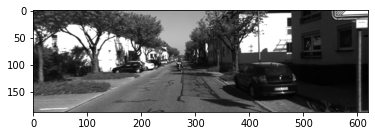

620 188
arg_minarg_min  arg_min18 13

arg_min181813 


1218

arg_minarg_min12arg_min  18arg_min
18 1318

arg_minarg_min  12 
181212



18arg_min
 arg_min12arg_minarg_min
 12arg_min 12
  12
1312
18
12arg_min13arg_min


18  
13arg_min


arg_min12arg_minarg_min 12 1818
 

 arg_min12131813



arg_min  1318arg_min12

1812121213




arg_min12arg_minarg_minarg_min
   arg_min 1218 

181218
18
arg_min
  1812
12
1313arg_min
arg_min 

 12arg_min
1213 

12arg_min
18
 13
12

arg_min
arg_minarg_min 
13 1812arg_min1213

  

12arg_min1818
arg_min1212
 
12 13arg_min13

 13
arg_min17
13

17
arg_minarg_min
18
 

arg_min12 arg_min12 
arg_min
18 
arg_min 1212
18
 121312
arg_min 12

13
arg_min12
  17
arg_minarg_min13 

 13arg_min121713 

12arg_min

arg_min1312
  
12

121317
12arg_minarg_min


17 12arg_minarg_min 13 
12
arg_min 


13 12arg_min12
 
arg_min18121212

 
13arg_min
arg_min12
13 arg_min
 18
1312 17
12


arg_minarg_min
12 17 
arg_min12
 13arg_min
1812


arg_min
12arg_min12 13
12 
17
arg_min 12
1217


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image  
from scipy.spatial.distance import cdist, sqeuclidean
from scipy.misc import imresize
from multiprocessing import Pool, freeze_support
from itertools import repeat
from functools import partial
import inspect


#left_img = Image.open("image/Stereovision/data/left/000000.png")  
#right_img = Image.open("image/Stereovision/data/left/000000.png") 
left_img = mpimg.imread('image/Stereovision/data/left/000000.png')
print(left_img)
right_img = mpimg.imread('image/Stereovision/data/right/000000.png')

left_img = np.array(imresize(left_img, float(0.5), interp='bicubic'), dtype=np.float32)
right_img = np.array(imresize(right_img, float(0.5), interp='bicubic'), dtype=np.float32)

#left_img = left_img.resize((int(width/2), int(height/2)))
#right_img = right_img.resize((int(width/2), int(height/2)))
 
plt.imshow(left_img, cmap='gray')
plt.show()


K = np.loadtxt('image/Stereovision/data/K.txt')
K[1:2, :] = K[1:2, :] / 2;

poses = np.loadtxt('image/Stereovision/data/poses.txt')

# Given by the KITTI dataset:
baseline = 0.54

# pretuned parameters
patch_radius = 9;
min_disparity = 5;
max_disparity = 50;

def inner_loop(h, patch_radius, left_img, right_img, height, width, min_disparity, max_disparity):
    arr = []
    for w in range(patch_radius+max_disparity,width-patch_radius-1):
        # MANUAL disparity
        """
        distance = float("inf")
        disparity = 0
        for x in range(w,max(patch_radius+1,w-max_disparity),-1):
            disp = w-x;
            patch_left = left_img[h - patch_radius : h + patch_radius, w - patch_radius : w + patch_radius].reshape(-1);
            patch_right = right_img[h - patch_radius : h + patch_radius, x - patch_radius : x + patch_radius].reshape(-1);
            d = cdist([patch_left], [patch_right], 'sqeuclidean');
            
            if (d < distance):
                disparity = disp;
                distance = d;
            # set disparity outside of disparity range to 0  
        """
        # Vectorized
        
        patch_left = left_img[h - patch_radius : h + patch_radius, w - patch_radius : w + patch_radius].reshape(-1);
        vec_r = []
        for x in range(w,max(patch_radius+1,w-max_disparity),-1):
            # get patched and make them 1-d
            patch_right = right_img[h - patch_radius : h + patch_radius, x - patch_radius : x + patch_radius].reshape(-1);
            vec_r.append(patch_right)
        #print(vec_r.shape)

        pdist = cdist([patch_left], vec_r, 'sqeuclidean')
        arg_min = np.argmin(pdist)
        print("arg_min", arg_min)

        disparity = arg_min
        
        if (disparity < min_disparity or disparity > max_disparity):
            disparity = 0;
        print(disparity)
        arr.append([h, w, disparity])
    return arr
    

def get_disparity(left_img, right_img, patch_radius, min_disparity, max_disparity):
    height, width = left_img.shape
    print(width, height)
    disparity_image = np.zeros((height, width))
    
    with open('image/Stereovision/data/tmp_func.py', 'w') as file:
        file.write("import numpy as np\n")
        file.write("from scipy.spatial.distance import cdist\n")
        file.write(inspect.getsource(inner_loop).replace(inner_loop.__name__, "task"))

    from image.Stereovision.data.tmp_func import task
    func = partial(task, patch_radius=patch_radius, left_img=left_img, right_img=right_img, height=height, width=width, min_disparity=min_disparity, max_disparity=max_disparity)
    #Iterative
    """
    for h in range(patch_radius,height-patch_radius-1):
        print(h)
        res_array = inner_loop(h,patch_radius, left_img, right_img, height, width, min_disparity, max_disparity)
        for h,w,res in res_array:
            disparity_image[h,w]=res
    """
    #Parallelized
    p=Pool(8)
    res_array = p.map(func, range(patch_radius,height-patch_radius-1))
    p.close()
    for inner in res_array:
        for h,w,res in inner:  
            disparity_image[h,w]=res

    plt.imshow(disparity_image)
    plt.show()
    
freeze_support() 
get_disparity(left_img, right_img, patch_radius, min_disparity, max_disparity)

